# 블랙 - 리터만 모형
> **MVO 모델의 한계**

- 과거 데이터에만 의존하기 때문에, 현실적으로 반영이 힘듦
- 추정오차의 문제점 : 입력 데이터가 조금만 변화해도 결과값이 크게 변함, 민감하게 반응하여 모형의 안정성이 낮음
- 자산군 집중 배분 현상 : MVO를 이용하여 자산을 배분하는 경우, 한쪽 자산에만 치우치는 경향이 두드러짐. 예를 들면 국가별 자산배분을 실행하는 경우, 미국주식에만 극단적으로 몰리는 현상이 발생, 이는 수익률과 위험요소만 고려했기 때문
- 해결 : 추정오차 축소법, 고차모멘트 , VaR활용, 블랙리터만 모형

> **Black Litterman Model 개요**

- 1990 골드만삭스에 근무하던 블랙과 리터만에 의해 개발된 포트폴리오 배분 수학적 모델
- MVO모형이 가지고 있는 단점을 해결, 투자자의 시장전망을 직관적으로 반영할 수 있는 모형
- 자산배분 비율을 비례적(시장포트폴리오 비율)이라는 균형가정을 바탕으로 투자자의 개인적 시장전망 견해를 고려하여 맞춤식 자산배분 비율을 정함
- MVO는 지배원리에 의한 선택을 위해 모든 자산의 기대수익률과 공분산 데이터를 지녀야 하는 반면, 블랙-리터만 모형은 자산데이터만 있으면 자산배분 가능

> **패키지 설치**

- pacman의 p_load 함수는 인스톨 되어있지 않은 패키지를 설치해, library를 자동으로 적용해주며, 인스톨 되어 있는 패키지는 자동으로 library 처리를 해준다

In [2]:
install.packages("pacman")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
pacman::p_load(dplyr,tidyquant,tidyverse,plotly)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘globals’, ‘later’, ‘listenv’, ‘parallelly’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘furrr’, ‘htmlwidgets’, ‘crosstalk’, ‘promises’, ‘Rcpp’, ‘warp’, ‘BH’, ‘fracdiff’, ‘lmtest’, ‘tseries’, ‘urca’, ‘RcppArmadillo’, ‘RcppRoll’, ‘future’, ‘quadprog’, ‘zoo’, ‘recipes’, ‘rsample’, ‘plotly’, ‘padr’, ‘slider’, ‘anytime’, ‘forecast’, ‘tsfeatures’, ‘PerformanceAnalytics’, ‘quantmod’, ‘lazyeval’, ‘Quandl’, ‘riingo’, ‘alphavantager’, ‘timetk’, ‘timeDate’, ‘TTR’, ‘xts’



tidyquant installed




csv 파일은 해당 ticker에 대한 로그 수익률을 나타낸 데이터다. csv파일을 읽은 후 Date 열은 알맞게 전처리 해주었다.

In [7]:
data = read.csv("https://raw.githubusercontent.com/parkminhyung/R-code-for-finance/master/data.csv")  %>%
  mutate(
    Date = gsub("\\.","-",x=Date) %>%
      as.Date()
  ) %>%
  column_to_rownames("Date")

head(data)

,APPL,AMZN,MSFT,GS,PFZR,SPX,UST3M..Rf.
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1999-05-31,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000000,0.0000
1999-06-30,0.0741080,0.0521686,0.1113170,0.0615074,0.0184621,0.053037836,0.0038
1999-07-30,0.1743534,-0.2223047,-0.0495556,-0.1164172,-0.0700512,-0.032557179,0.0038
1999-08-31,0.1484200,0.2163728,0.0756050,-0.0725423,0.1085010,-0.006169879,0.0039
1999-09-30,-0.0173917,0.2503313,-0.0218445,0.0197010,-0.0510139,-0.029039610,0.0039
1999-10-29,0.2336149,-0.1230705,0.0218445,0.1518060,0.1008812,0.060945289,0.0041


Risk-free rate는 0으로 가정하는 경우도 있으나, 예시에서는 UST 3M을 기준으로 설정해주도록 한다.

In [8]:
exr_data = data %>%
  mutate(
    across(.cols = -`UST3M..Rf.`,.fns = ~ . - `UST3M..Rf.`)
  )
head(exr_data)

,APPL,AMZN,MSFT,GS,PFZR,SPX,UST3M..Rf.
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1999-05-31,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.0000
1999-06-30,0.0703080,0.0483686,0.1075170,0.0577074,0.0146621,0.04923784,0.0038
1999-07-30,0.1705534,-0.2261047,-0.0533556,-0.1202172,-0.0738512,-0.03635718,0.0038
1999-08-31,0.1445200,0.2124728,0.0717050,-0.0764423,0.1046010,-0.01006988,0.0039
1999-09-30,-0.0212917,0.2464313,-0.0257445,0.0158010,-0.0549139,-0.03293961,0.0039
1999-10-29,0.2295149,-0.1271705,0.0177445,0.1477060,0.0967812,0.05684529,0.0041


> **CAPM expected return 구하기**

- 후에 블랙리터만 기대수익률과 CAPM의 expected return과 비교하기 위해 excess return을 구해주도록 한다. CAPM의 excess return의 공식은 아래와 같다.


CAPM = r<sub>f</sub> + β (r<sub>m</sub> – r<sub>f</sub>)
- r<sub>f</sub> : Risk-free rate
- β : 개별 주식의 베타
- r<sub>m</sub> : 마켓 수익률
- r<sub>m</sub> – r<sub>f</sub> : 초과수익률

CAPM을 위한 데이터를 준비해주도록한다.

In [9]:
#과거수익률 평균
historical_return_avg = colMeans(data)*12
#초과수익률 평균
excess_return_avg = colMeans(exr_data)*12

# 과거 로그수익률에 대한 표준편차
stdev = data %>%
  summarise(
    across(.cols = everything(),
           .fns = sd))*sqrt(12)

# 각 자산에 대한 베타, 회귀식의 기울기로 구함
beta = data %>%
  summarise(
    across(.cols = -`SPX`,
           .fns = ~coef(lm(.~`SPX`))[[2]],
           .names = "{.col}"
    )
  )

In [10]:
historical_return_avg

APPL       AMZN       MSFT         GS       PFZR        SPX UST3M..Rf. 
0.26341998 0.16985655 0.08605329 0.06892220 0.01587905 0.05314264 0.01563055

In [11]:
excess_return_avg

APPL         AMZN         MSFT           GS         PFZR          SPX 
0.2477894356 0.1542260073 0.0704227418 0.0532916509 0.0002485047 0.0375120973 
  UST3M..Rf. 
0.0156305455

In [12]:
stdev

APPL,AMZN,MSFT,GS,PFZR,SPX,UST3M..Rf.
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.4170154,0.4540086,0.2857075,0.320292,0.2112687,0.1461897,0.005186823


In [13]:
beta

APPL,AMZN,MSFT,GS,PFZR,UST3M..Rf.
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.428806,1.481541,1.188123,1.52851,0.6680935,-0.003108984


각 자산의 CAPM 기대 수익률을 구한다

In [15]:
capm_ex_return = historical_return_avg[["UST3M..Rf."]] + beta*(historical_return_avg[["SPX"]]-historical_return_avg[["UST3M..Rf."]])
capm_ex_return

APPL,AMZN,MSFT,GS,PFZR,UST3M..Rf.
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.06922804,0.07120625,0.06019952,0.07296817,0.04069213,0.01551392


> **Black Litterman Model 적용과정**
>
> 균형기대수익률(implied equilibrium return :Π) + 시장전망 수익률 = 블랙리터만 기대수익률

1. 자산의 시가총액 비율을 이용하여 균형기대수익률 계산

- 역최적화 : 시장 포트폴리오 비중 자체에 내재하고 있는 투자자의 기대가 결합된 수익률을 역으로 유도하는 방식



> 자산의 개수가 N개인 경우의 균형기대수익률(Π)

| Π = λΣw<sub>mkt</sub> = **μ+ε<sub>Π</sub>** ,  εΠ~N(0,τΣ)    |
| ------------------------------------------------------------ |
| λ : 위험회피계수<br />Σ : 과거수익률 공분산 행렬 (NXN)<br />w<sub>mkt</sub> : 시장포트폴리오 투자비중 (자본시장 시총비율)백터(NX1)<br />μ : 분포를 알고 싶은 모수 실제 기대수익률 벡터(NX1)<br />ε<sub>Π</sub> : 기대수익률 벡터 오차향<br />τ : 위험 조정상수 |

- λ =  $\frac{rm –rf}{𝜎m2}$
- Σ = Covariance Matrix (N X N)
- Wmkt = 각 시총에 대한 weight

In [17]:
#λ
lam = excess_return_avg[["SPX"]]/(stdev[["UST3M..Rf."]])^2

#Σ
cov = cov(data) %>%
  .[1:5,1:5]

#Wmkt : weighted Market cap
mkt = c(2662.00,1482.00,2173.00,116,273)
w_mkt = mkt/sum(mkt)
names(w_mkt) = c(names(data)[1:5])

In [18]:
lam

[1] 1394.339

In [19]:
cov

,APPL,AMZN,MSFT,GS,PFZR
APPL,0.0144918202,0.005680071,0.0042312648,0.004842324,0.0004168902
AMZN,0.0056800710,0.017176982,0.0044137867,0.003556490,0.0008085690
MSFT,0.0042312648,0.004413787,0.0068023966,0.003391677,0.0008838236
GS,0.0048423237,0.003556490,0.0033916767,0.008548914,0.0010763574
PFZR,0.0004168902,0.000808569,0.0008838236,0.001076357,0.0037195374


In [20]:
w_mkt

APPL       AMZN       MSFT         GS       PFZR 
0.39695795 0.22099612 0.32403817 0.01729794 0.04070981

In [ ]:
w_mkt %>%
  as.data.frame() %>%
  plot_ly(
    labels = names(w_mkt),
    values = .[,1],
    type = "pie",
    extposition = 'inside',
    textinfo = 'label+percent',
    insidetextfont = list(color = '#FFFFFF'),
    hoverinfo = 'text',
    marker = list(colors = colors,
                  line = list(color = '#FFFFFF', width = 1))
  ) %>%
  layout(title = "<b>Market Cap weight</b>",
         showlegend = FALSE)

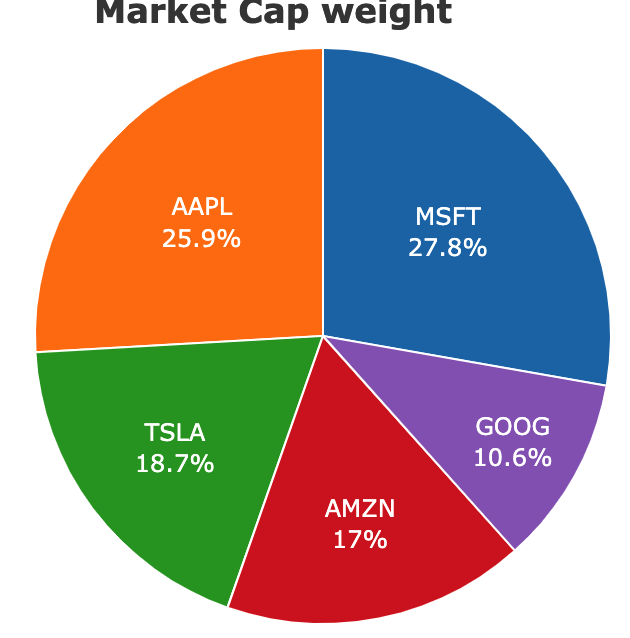

균형수익률을 구해보도록 한다

In [24]:
#implied Equilibrium Return(Π)
ier = lam*(cov %*% w_mkt)
ier

APPL,11.823638
AMZN,10.562773
MSFT,6.907487
GS,5.575822
PFZR,1.116324


> **투자자의 시장전망 표현(P, Q, Ω)**

- 시장전망 행렬표현(P, Q) :

- 자산군의 시장행렬(P, KxN, K는 전망의 수, N은 자산개수),

  - 예, 상대적전망P1과 절대적 전망 P2, 전망은 1,0,-1로 표현하며, 1은 양의 수익률 전망, 0은 행보 혹은 전망하지 않음, -1은 음의 수익률 전망.

  - 예, 자산군 A,B,C,D 4개이므로, N은 4

- 시장전망 수익률행렬 Q

  - 상대적 시장전망(Q<sub>P1</sub>) : 자산간 비교를 통한 전망, 예) 자산A의 수익률은 C의 수익률보다 2% 높을 것이다, Q<sub>P1</sub> = 2%, P1 = [1,0,-1,0]
  - 절대적 시장전망(Q<sub>P2</sub>) : 자산 자체의 전망, 예) 자산 B의 수익률은 3%일 것이다, Q<sub>P2</sub> = 3%, P2 = [0,1,0,0]
  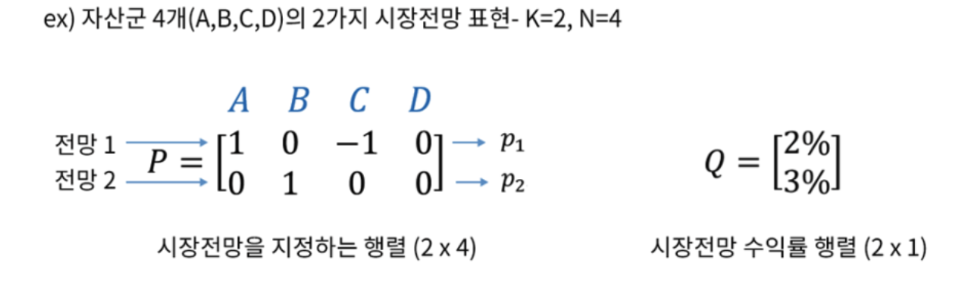

출처 : 네이버 덩니루님 블로그

- 예시에서는,
  - 전망 1 : GS가 PFZR 보다 0.5% 높을 것이다
  - 전망 2 : AMZN이 MSFT 보다 1% 높을 것이다
  - 전망 3 : MSFT가 PFZR보다 0.5% 높을 것이다.
- 그래서 전망(P) 매트릭스는 P, outperformance (Q)는 아래와 같이 나타낸다

In [25]:
#link matrix(P)
P = rbind(
  c(0,0,0,1,-1),
  c(0,1,-1,0,0),
  c(0,0,1,0,-1)
)

#outperformance(Q)
Q = c(0.005,0.01,0.005) %>%
  as.matrix(
    ncol = 1
  )


In [26]:
P

0,0,0,1,-1
0,1,-1,0,0
0,0,1,0,-1


In [27]:
Q

0.005
0.010
0.005


> **시장전망의 불확실성 행렬표현 (Ω)**
- Ω = τPΣP<sup>T

- 예시에서는 τ(tau) 를 1로 가정한다
- P: 위의 전망 matrix
- Σ: covariance matrix
- P<sup>T</sup>: P 매트릭스의 전치행렬

In [28]:
#omega, assumption : tau =1
om = P %*% cov %*% t(P)
om

0.0101157368,0.0002400677,0.005151033
0.0002400677,0.0151518049,-0.002313355
0.0051510330,-0.0023133552,0.008754287


> **블랙리터만 기대수익률: μ<sub>BL</sub>**

μ<sub>BL</sub>  = [ (τΣ)<sup>-1</sup> + P'Ω<sup>-1</sup> **P** ]<sup>-1</sup> [ (τΣ)<sup>-1</sup>**<u>Π</u>** + P' P'Ω<sup>-1</sup><u>**Q**</u> ] ε ~ N(0,V)

- 예시에서는,<br> i = [ (τΣ)<sup>-1</sup> + P'Ω<sup>-1</sup> **P** ]<sup>-1</sup>,</br> ii = [ (τΣ)<sup>-1</sup>**<u>Π</u>** + P' P'Ω<sup>-1</sup><u>**Q**</u> ]</br> 두 부분으로 나눠 곱한다

In [30]:
i = solve(solve(cov)+t(P)%*%solve(om) %*% P)
ii = solve(cov) %*% ier + t(P) %*% solve(om) %*% Q
BL_return = i %*% ii
BL_return

APPL,10.059568
AMZN,6.961614
MSFT,5.128971
GS,4.463138
PFZR,2.230889


블랙리터만 기대수익률로 구한 각 자산의 기대수익률은 애플(APPL)10%, 아마존(AMZN) 6.96% 식으로 나타낸다. <br> 이제 위에서 구한 CAPM 기대수익률과 비교해보도록한다.

---



In [31]:
return_data = cbind(
  BL_return,
  t(capm_ex_return*100)[,1]
) %>%
  `colnames<-`(c("BL_return","CAPM_return"))
return_data

Warning message in cbind(BL_return, t(capm_ex_return * 100)[, 1]):
“number of rows of result is not a multiple of vector length (arg 2)”


,BL_return,CAPM_return
APPL,10.059568,6.922804
AMZN,6.961614,7.120625
MSFT,5.128971,6.019952
GS,4.463138,7.296817
PFZR,2.230889,4.069213


두 리턴에 대한 시각화

In [ ]:
return_data %>%
  as.data.frame() %>%
  plot_ly(
    x= rownames(.),
    y= ~BL_return,
    type = "bar",
    name = "BL Return"
  ) %>%
  add_trace(
    y= ~CAPM_return,
    name = "CAPM Return"
  )

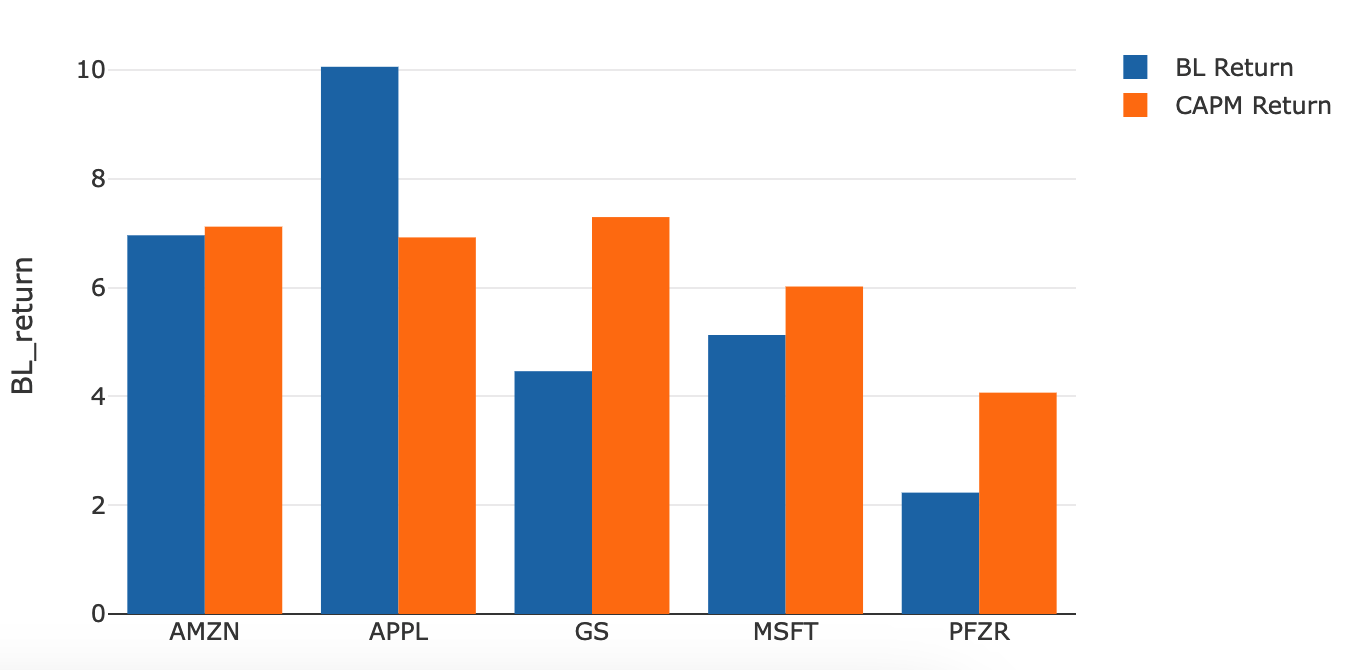